In [ ]:
pip install torch torchvision

In [13]:
import sys
sys.path.append(r"C:\Users\asus4\Desktop\fire_sim\forestfire_sim\forest_fire_sim\forestfire_sim")
from config import DEM, FEATURE_STACK, PREDICTION_MAP
from predict import predict_full_image


In [ ]:
#predict

In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import rasterio

# If running in notebook: manually set paths (optional fallback)
try:
    from config import DEM, FEATURE_STACK, PREDICTION_MAP
except ImportError:
    DEM = "data/uttarakhand_dem.tif"
    FEATURE_STACK = "data/feature_stack.npz"
    PREDICTION_MAP = "outputs/prediction_day1.tif"

# -----------------------------
# 🔶 U-Net Model Definition
# -----------------------------
class UNet(nn.Module):
    def __init__(self, in_channels=7, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_c)
            )

        self.enc1 = nn.Sequential(conv_block(in_channels, 64), conv_block(64, 64))
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(conv_block(64, 128), conv_block(128, 128))
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(conv_block(128, 256), conv_block(256, 256))

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = nn.Sequential(conv_block(256, 128), conv_block(128, 64))
        self.up1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        out = self.final(d1)
        return self.sigmoid(out)

# -----------------------------
# 🔷 Dataset
# -----------------------------
class FireDataset(Dataset):
    def __init__(self, feature_path, label_path, patch_size=64):
        self.data = np.load(feature_path)["features"]  # (C, H, W)
        self.labels = np.load(label_path)             # (H, W)
        self.patch_size = patch_size

        self.indices = []
        h, w = self.labels.shape
        for i in range(0, h - patch_size, patch_size):
            for j in range(0, w - patch_size, patch_size):
                self.indices.append((i, j))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i, j = self.indices[idx]
        x = self.data[:, i:i+self.patch_size, j:j+self.patch_size]
        y = self.labels[i:i+self.patch_size, j:j+self.patch_size]
        return torch.FloatTensor(x), torch.FloatTensor(y).unsqueeze(0)

# -----------------------------
# 🧪 Train U-Net
# -----------------------------
def train_model():
    dataset = FireDataset("data/feature_stack.npz", "data/target_labels.npy", patch_size=64)
    loader = DataLoader(dataset, batch_size=4, shuffle=True)

    model = UNet(in_channels=dataset.data.shape[0])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print("🧠 Training U-Net on patch dataset...")
    for epoch in range(5):
        model.train()
        total_loss = 0
        for x, y in loader:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(loader):.4f}")

    os.makedirs("models", exist_ok=True)
    torch.save(model.state_dict(), "models/unet_fire_model.pth")
    print("✅ Model saved to models/unet_fire_model.pth")

# -----------------------------
# 🔮 Predict Full Image
# -----------------------------
def predict_full_image():
    print("🛰  Predicting full-region fire probability map...")

    data = np.load(FEATURE_STACK)["features"]  # (C, H, W)
    c, h, w = data.shape
    model = UNet(in_channels=c)
    model.load_state_dict(torch.load("models/unet_fire_model.pth", map_location="cpu"))
    model.eval()

    input_tensor = torch.FloatTensor(data).unsqueeze(0)  # (1, C, H, W)
    with torch.no_grad():
        output = model(input_tensor)[0, 0].numpy()  # (H, W)

    fire_prob_map = np.clip(output, 0, 1)

    # Save as GeoTIFF
    with rasterio.open(DEM) as src:
        profile = src.profile
        profile.update(count=1, dtype="float32")

        os.makedirs(os.path.dirname(PREDICTION_MAP), exist_ok=True)
        with rasterio.open(PREDICTION_MAP, "w", **profile) as dst:
            dst.write(fire_prob_map.astype("float32"), 1)

    print("🔥 Fire probability saved to:", PREDICTION_MAP)

# -----------------------------
# ▶️ Main Runner
# -----------------------------
if __name__ == "__main__":
    train_model()
    predict_full_image()


🧠 Training U-Net on patch dataset...
Epoch 1: Loss = 0.7176
Epoch 2: Loss = 0.6902
Epoch 3: Loss = 0.6690
Epoch 4: Loss = 0.6512
Epoch 5: Loss = 0.6349
✅ Model saved to models/unet_fire_model.pth
🛰  Predicting full-region fire probability map...
🔥 Fire probability saved to: outputs/prediction_day1.tif


In [ ]:
#visualize.py

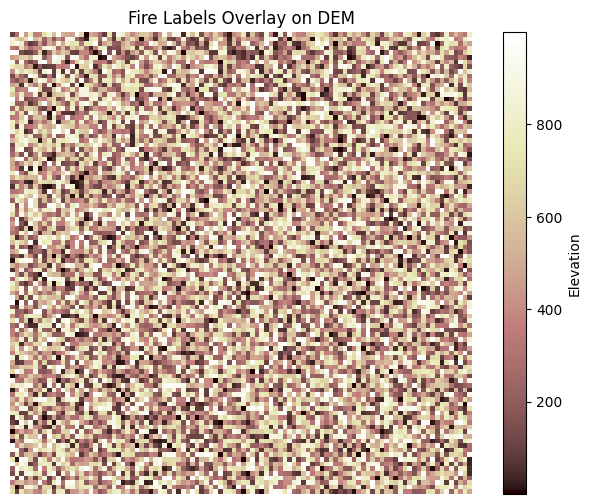

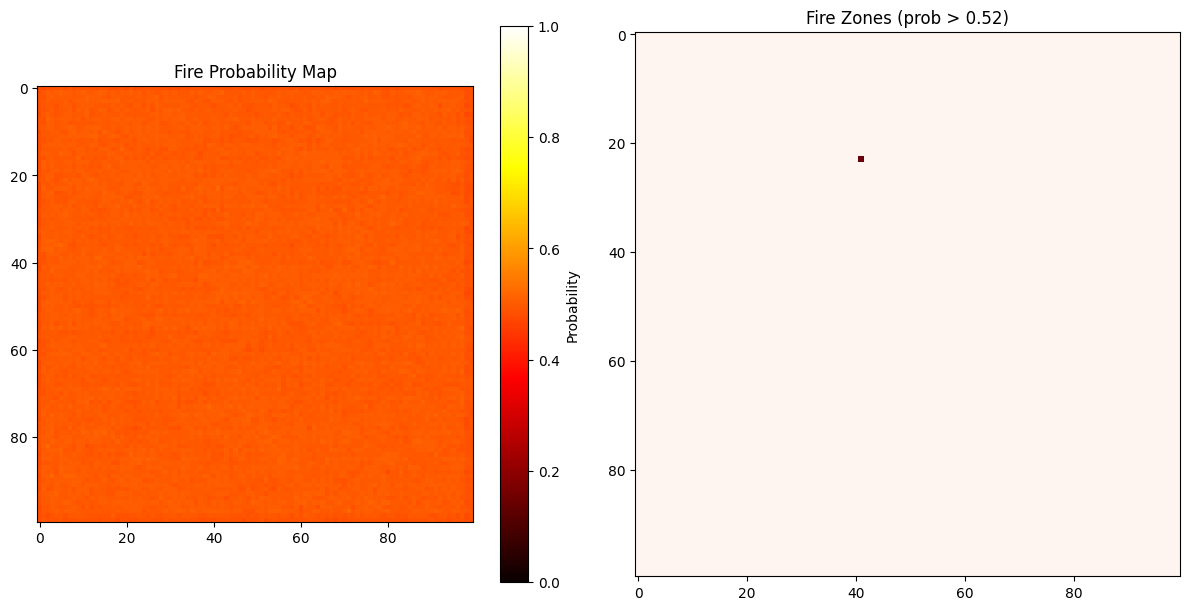

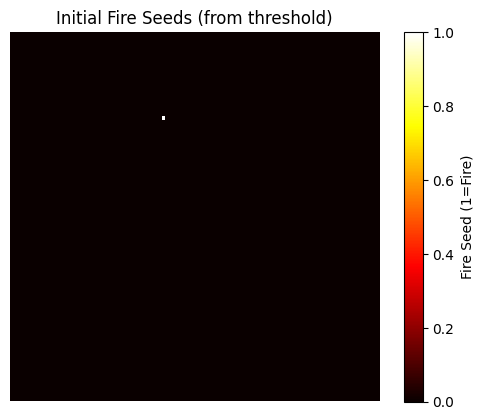

Fire Prediction Stats
Min: 0.47311655
Max: 0.5213508
Mean: 0.49790737


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os

def show_fire_probability_map(prediction_path, threshold=0.6):
    """
    Visualize the fire probability map and highlight high-risk zones.
    """
    with rasterio.open(prediction_path) as src:
        fire_map = src.read(1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot full fire probability map
    im1 = axs[0].imshow(fire_map, cmap="hot", vmin=0, vmax=1)
    axs[0].set_title("Fire Probability Map")
    fig.colorbar(im1, ax=axs[0], label="Probability")

    # Plot binary fire zones above threshold
    fire_zones = (fire_map > threshold).astype(np.uint8)
    im2 = axs[1].imshow(fire_zones, cmap="Reds")
    axs[1].set_title(f"Fire Zones (prob > {threshold})")
    fig.tight_layout()
    plt.show()

def show_label_overlay(dem_path, label_path):
    """
    Overlay binary fire label map on DEM for spatial context.
    """
    with rasterio.open(dem_path) as src:
        dem = src.read(1)
    
    label = np.load(label_path)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(dem, cmap="Greys", interpolation="none")
    ax.imshow(label, cmap="Reds", alpha=0.5)
    ax.set_title("Fire Labels Overlay on DEM")
    plt.colorbar(ax.imshow(dem, cmap="pink"), label="Elevation")
    plt.axis("off")
    plt.show()

def preview_fire_seed(prob_map_path, threshold=0.6):
    """
    Visualize the seed zones selected for fire spread simulation.
    """
    with rasterio.open(prob_map_path) as src:
        prob_map = src.read(1)

    initial_fire = (prob_map > threshold).astype(np.uint8)

    plt.imshow(initial_fire, cmap="hot")
    plt.title("Initial Fire Seeds (from threshold)")
    plt.colorbar(label="Fire Seed (1=Fire)")
    plt.axis("off")
    plt.show()

def summarize_prediction_stats(prediction_path):
    """
    Print basic statistics from predicted fire probability map.
    """
    with rasterio.open(prediction_path) as src:
        fire_map = src.read(1)
        print("Fire Prediction Stats")
        print("Min:", np.min(fire_map))
        print("Max:", np.max(fire_map))
        print("Mean:", np.mean(fire_map))

# Example usage block
if __name__ == "__main__":
    DEM_PATH = "data/uttarakhand_dem.tif"
    LABEL_PATH = "data/target_labels.npy"
    PRED_PATH = "outputs/prediction_day1.tif"

    show_label_overlay(DEM_PATH, LABEL_PATH)
    show_fire_probability_map(PRED_PATH, threshold=0.52)
    preview_fire_seed(PRED_PATH, threshold=0.52)
    summarize_prediction_stats(PRED_PATH)


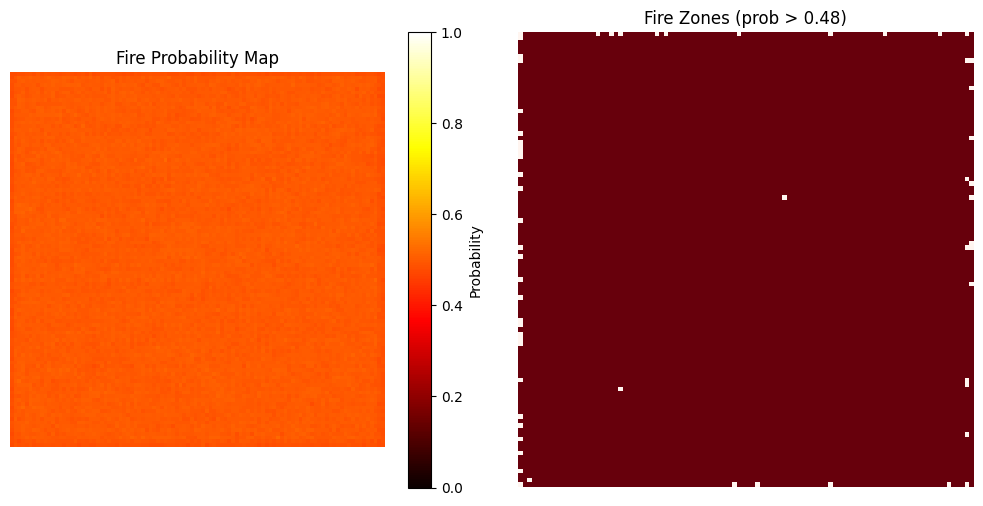

In [44]:
show_fire_prediction_map("outputs/prediction_day1.tif", threshold=0.48)

In [40]:
inspect_fire_map_stats("outputs/prediction_day1.tif")


Fire Prediction Stats
Min: 0.47311655
Max: 0.5213508
Mean: 0.49790737


In [ ]:
pip install imageio


In [ ]:
#simulate.py

In [42]:
import numpy as np
import rasterio
from forestfire_sim.config import DEM, PREDICTION_MAP
import matplotlib.pyplot as plt
import imageio
import os

def simulate_fire_spread(prob_map_path, dem_path, out_dir="outputs/", hours=[1, 2, 3, 6, 12]):
    os.makedirs(out_dir, exist_ok=True)

    # Load fire probability map
    with rasterio.open(prob_map_path) as src:
        fire_map = src.read(1)
        profile = src.profile

    # Load elevation for slope dummy (here used as static terrain factor)
    with rasterio.open(dem_path) as dem_src:
        slope = dem_src.read(1)

    # Create binary ignition zones
    ignition = (fire_map > 0.48).astype(np.uint8)#temp treshold for ignition

    # Create empty spread map
    H, W = ignition.shape
    spread = np.zeros((H, W), dtype=np.uint8)
    spread[ignition == 1] = 1

    # Store frames for animation
    frames = [spread.copy()]

    # Dummy rule: spread to 8-neighbors
    for hour in range(1, max(hours) + 1):
        new_spread = spread.copy()

        for i in range(1, H-1):
            for j in range(1, W-1):
                if spread[i, j] == 1:
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:
                            if (dx, dy) != (0, 0):
                                ni, nj = i + dx, j + dy
                                # Random + terrain filter
                                if np.random.rand() > 0.4 and slope[ni, nj] < 0.8:
                                    new_spread[ni, nj] = 1

        spread = new_spread.copy()

        if hour in hours:
            # Save raster at milestone hour
            hour_path = os.path.join(out_dir, f"spread_{hour}h.tif")
            with rasterio.open(hour_path, "w", **profile) as dst:
                dst.write(spread.astype("uint8"), 1)
            print(f"Saved: {hour_path}")

        # Save frame for animation
        frames.append(spread.copy())

    # Save animation
    gif_path = os.path.join(out_dir, "spread_1_2_3_6_12h.gif")
    imageio.mimsave(gif_path, [frame * 255 for frame in frames], duration=0.5)
    print(f"Fire spread animation saved at: {gif_path}")


In [43]:
simulate_fire_spread(
    prob_map_path="outputs/prediction_day1.tif",
    dem_path="data/uttarakhand_dem.tif"
)

Saved: outputs/spread_1h.tif
Saved: outputs/spread_2h.tif
Saved: outputs/spread_3h.tif
Saved: outputs/spread_6h.tif
Saved: outputs/spread_12h.tif
Fire spread animation saved at: outputs/spread_1_2_3_6_12h.gif
